In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba
from sklearn.cluster import KMeans

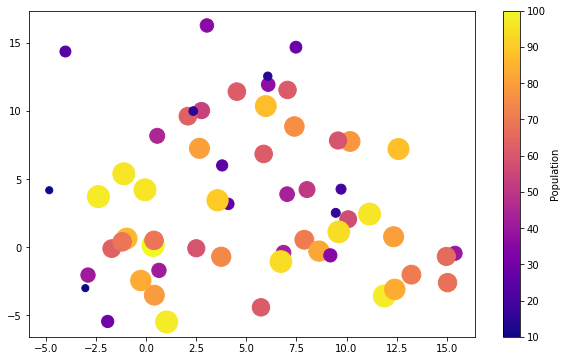

In [59]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=3, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')



In [60]:
Hs = 1
N = 18
n_clusters = 3
Is = 10
Imin = 0.1
ImaxSol = Imin*2

I_min_sol = 5
p = 100

In [61]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [62]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    return 0

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)





In [63]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

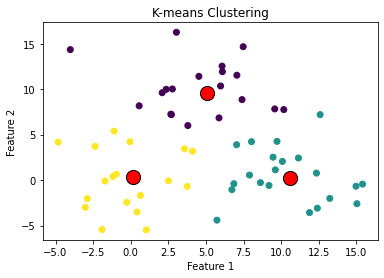

In [64]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [65]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))



t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

/home/ines/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_12799/3802933048.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  6.01969838142395
     fun: 0
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])
 message: 'Iteration limit reached'
    nfev: 3892
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 5.50877415, 10.46618082, 12.88006465,  0.01828775,  2.83654304,
       -0.69862386,  7.18453906, 12.54840504,  9.36979975,  0.5744203 ,
       -0.32685343,  0.28505946,  7.02857389,  7.82324127,  9.66198157,
        7.25444044, -0.18127789, -3.5076529 ,  3.71213728,  3.15938728,
       10.76972229,  2.5718066 ,  0.12162501,  3.97071445,  2.25372196,
        7.5349412 ,  7.11351284, -0.55261528,  5.7014045 , -3.77838561,
        2.85486989,  9.53736686, 14.93681314, -1.79075524, -1.05921154,
       -1.65121168])
Résultat de l'optimisation: 0
Valeurs optimales des variables: [ 5.50877415 10.46618082 12.88006465  0.01828775  2.83654304 -0.69862386
  7.1845

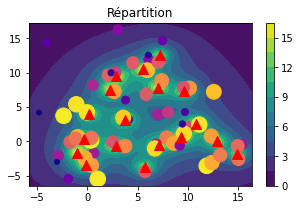

In [66]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size/2)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 100, label = "Satellites")
plt.title("Répartition")
plt.savefig("S3-5Cascade1.pdf")


Voila donc on a repris exactement le même problème que dans S3-3 et maintenant on va refaire un nouveau problème comme dans S3-4 mais les conditions initiales seront enft les positions des satellites qu'on vient de trouver et on va également mettre les intensités à 10 au départ

In [67]:
@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    somme = 0
    for i in range(N) : 
        somme += x[2*N+i]
    return somme
  

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += x[2*N+i]/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)



def contrainte_intensity(x) : 
    return x[2*N:]



In [68]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

centers = centers.reshape(n_clusters*2)
x0 = solution_position
x0_intensity = np.ones(N)*10
x0 = np.hstack((x0, x0_intensity))
print(x0)
        
myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
myc4 = NonlinearConstraint(contrainte_intensity, 0, 20)
contraintes = [myc1, myc4]




t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte_intensity(resultat.x))

[ 5.50877415 10.46618082 12.88006465  0.01828775  2.83654304 -0.69862386
  7.18453906 12.54840504  9.36979975  0.5744203  -0.32685343  0.28505946
  7.02857389  7.82324127  9.66198157  7.25444044 -0.18127789 -3.5076529
  3.71213728  3.15938728 10.76972229  2.5718066   0.12162501  3.97071445
  2.25372196  7.5349412   7.11351284 -0.55261528  5.7014045  -3.77838561
  2.85486989  9.53736686 14.93681314 -1.79075524 -1.05921154 -1.65121168
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.        ]


/home/ines/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_12799/374032613.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  11.399374723434448
     fun: 162.71417195632057
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])
 message: 'Optimization terminated successfully'
    nfev: 4901
     nit: 88
    njev: 88
  status: 0
 success: True
       x: array([ 4.62618948, 11.28322345, 12.28511014,  0.75741351,  3.46635574,
       -0.51779815,  6.40263719, 10.77009301,  8.87540653,  0.7615909 ,
       -0.3820682 ,  0.10201252,  6.93926214,  7.76770458, 10.03244653,
        7.65853178, -0.04498251, -3.10486707,  3.70077172,  3.46765804,
       10.76716043,  2.43971667, -0.03239528,  4.24117475,  2.15167266,
        7.5649639 ,  6.78996567, -0.95152558,  5.7283789 , -4.3595279 ,
        2.25661825,  9.54095228, 12.36261389, -2.93098693, -2.1902148 ,
       -3.39844958,  3.70393276,  5.86887348,  6.17739885

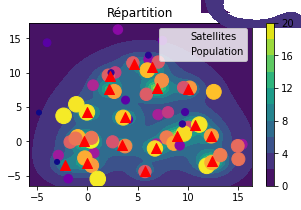

In [70]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += sol[2*N+i]/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size/2)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 100)
#Add a custom legend

plt.title("Répartition")
plt.savefig("S3-5Cascade2.pdf")


Et la dinguerie, on a enfait une intensité totale utilisée de 136 alors qu'avant, on avait une intensité de 180, toujours avec 18 satellites et notre condition d'avoir 80 prct est bien toujours respectée!!